In [1]:
from sklearn.model_selection import train_test_split
import random
from sklearn.utils import shuffle

# 数字の文字をID化
char2id = {str(i) : i for i in range(10)}

# 空白(10)：系列の長さを揃えるようのパディング文字
# -(11)：マイナスの文字
# _(12)：系列生成開始を知らせる文字
char2id.update({" ":10, "-":11, "_":12})

# 空白込みの３桁の数字をランダムに生成
def generate_number():
    number = [random.choice(list("0123456789")) for _ in range(random.randint(1, 3))]
    return int("".join(number))

# 確認
print(generate_number())

# 系列の長さを揃えるために空白パディング
def add_padding(number, is_input=True):
    number = "{: <7}".format(number) if is_input else "{: <5s}".format(number)
    return number

# 確認
num = generate_number()
print("\"" + str(add_padding(num)) + "\"")
print(len(add_padding(num)))

# データ準備
input_data = []
output_data = []

# データを５００００件準備する
while len(input_data) < 50000:
    x = generate_number()
    y = generate_number()
    z = x - y
    input_char = add_padding(str(x) + "-" + str(y))
    output_char = add_padding("_" + str(z), is_input=False)
    
    # データをIDにに変換
    input_data.append([char2id[c] for c in input_char])
    output_data.append([char2id[c] for c in output_char])
    
# 確認
print(input_data[987])
print(output_data[987])

# ７：３にデータをわける
train_x, test_x, train_y, test_y = train_test_split(input_data, output_data, train_size= 0.7)


# データをバッチ化するための関数
def train2batch(input_data, output_data, batch_size=100):
    input_batch = []
    output_batch = []
    input_shuffle, output_shuffle = shuffle(input_data, output_data)
    for i in range(0, len(input_data), batch_size):
      input_batch.append(input_shuffle[i:i+batch_size])
      output_batch.append(output_shuffle[i:i+batch_size])
    return input_batch, output_batch

3
"44     "
7
[6, 11, 4, 3, 10, 10, 10]
[12, 11, 3, 7, 10]


In [0]:
import torch
import torch.nn as nn
import torch.optim as optim

embedding_dim = 200
hidden_dim = 128
vocab_size = len(char2id)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Encoderクラス
class Encoder(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim):
        super(Encoder, self).__init__()
        self.hidden_dim = hidden_dim
        self.word_embeddings = nn.Embedding(vocab_size, embedding_dim, padding_idx=char2id[" "])
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
    
    def forward(self, sequence):
        embedding = self.word_embeddings(sequence)
        _, state = self.lstm(embedding)
        # state = (h, c)
        return state
      
    def embedding(self):
      return self.word_embeddings


# Decoderクラス
class Decoder(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim):
        super(Decoder, self).__init__()
        self.hidden_dim = hidden_dim
        self.word_embeddings = nn.Embedding(vocab_size, embedding_dim, padding_idx=char2id[" "])
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.hidden2linear = nn.Linear(hidden_dim, vocab_size)
        
    def forward(self, sequence, encoder_state):
        embedding = self.word_embeddings(sequence)
        output, state = self.lstm(embedding, encoder_state)
        output = self.hidden2linear(output)
        return output, state

encoder = Encoder(vocab_size, embedding_dim, hidden_dim).to(device)
decoder = Decoder(vocab_size, embedding_dim, hidden_dim).to(device)

# 損失関数
criterion = nn.CrossEntropyLoss()

# 最適化
encoder_optimizer = optim.Adam(encoder.parameters(), lr=0.001)
decoder_optimizer = optim.Adam(decoder.parameters(), lr=0.001)

In [3]:
# 学習

BATCH_NUM = 100
EPOCH_NUM = 100

all_losses = []
print("training ...")
for epoch in range(1, EPOCH_NUM+1):
    epoch_loss = 0
    # データをミニバッチに分ける
    input_batch, output_batch = train2batch(train_x, train_y, batch_size=BATCH_NUM)
    for i in range(len(input_batch)):
        
        # 勾配の初期化
        encoder_optimizer.zero_grad()
        decoder_optimizer.zero_grad()
        
        # データをテンソルに変換
        input_tensor = torch.tensor(input_batch[i], device=device)
        output_tensor = torch.tensor(output_batch[i], device=device)

        
        # Encoderの順伝搬
        encoder_state = encoder(input_tensor)

        # Decoderのインプット
        source = output_tensor[:, :-1]
        
        # Decoderの正解データ
        target = output_tensor[:, 1:]

        loss = 0
        decoder_output, _ = decoder(source, encoder_state)
        for j in range(decoder_output.size()[1]):
            loss += criterion(decoder_output[:, j, :], target[:, j])

        epoch_loss += loss.item()
        
        # 誤差逆伝播
        loss.backward()

        # パラメータ更新
        encoder_optimizer.step()
        decoder_optimizer.step()
    
    # 損失を表示
#     print("epoch", str(epoch), "loss", str(loss.item()))
    print("Epoch %d: %.2f" % (epoch, epoch_loss))
    all_losses.append(epoch_loss)
    if epoch_loss < 1: break
print("Done")

training ...
Epoch 1: 1907.24
Epoch 2: 1407.53
Epoch 3: 1214.46
Epoch 4: 1073.58
Epoch 5: 965.85
Epoch 6: 873.27
Epoch 7: 776.42
Epoch 8: 696.45
Epoch 9: 623.99
Epoch 10: 565.06
Epoch 11: 507.03
Epoch 12: 461.85
Epoch 13: 423.49
Epoch 14: 387.31
Epoch 15: 360.33
Epoch 16: 335.93
Epoch 17: 311.96
Epoch 18: 287.30
Epoch 19: 270.31
Epoch 20: 255.89
Epoch 21: 243.98
Epoch 22: 229.24
Epoch 23: 219.74
Epoch 24: 206.68
Epoch 25: 194.37
Epoch 26: 186.71
Epoch 27: 181.82
Epoch 28: 174.29
Epoch 29: 170.98
Epoch 30: 157.60
Epoch 31: 152.93
Epoch 32: 150.55
Epoch 33: 144.20
Epoch 34: 133.54
Epoch 35: 137.82
Epoch 36: 131.59
Epoch 37: 124.12
Epoch 38: 114.05
Epoch 39: 117.36
Epoch 40: 112.84
Epoch 41: 113.77
Epoch 42: 105.47
Epoch 43: 105.88
Epoch 44: 99.65
Epoch 45: 93.35
Epoch 46: 89.19
Epoch 47: 96.48
Epoch 48: 93.37
Epoch 49: 82.12
Epoch 50: 83.89
Epoch 51: 75.39
Epoch 52: 77.04
Epoch 53: 79.80
Epoch 54: 85.95
Epoch 55: 65.05
Epoch 56: 59.29
Epoch 57: 69.40
Epoch 58: 66.21
Epoch 59: 63.02
Epoch

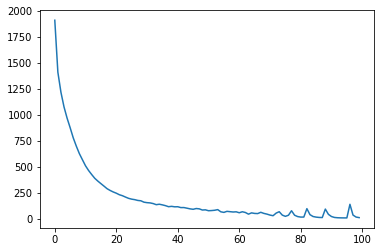

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(all_losses)

In [0]:
# Decoderのアウトプットのテンソルから要素が最大のインデックスを返す。つまり生成文字を意味する
def get_max_index(decoder_output):
  results = []
  for h in decoder_output:
    results.append(torch.argmax(h))
  return torch.tensor(results, device=device).view(BATCH_NUM, 1)
    
# 評価用データ
test_input_batch, test_output_batch = train2batch(test_x, test_y)
input_tensor = torch.tensor(test_input_batch, device=device)

predicts = []
for i in range(len(test_input_batch)):
  with torch.no_grad():
    encoder_state = encoder(input_tensor[i])
    
    # Decoderにはまず文字列生成開始を表す"_"をインプットにするので、"_"のtensorをバッチサイズ分作成
    start_char_batch = [[char2id["_"]] for _ in range(BATCH_NUM)]
    decoder_input_tensor = torch.tensor(start_char_batch, device=device)

    decoder_hidden = encoder_state
    batch_tmp = torch.zeros(100,1, dtype=torch.long, device=device)
    for _ in range(4):
      decoder_output, decoder_hidden = decoder(decoder_input_tensor, decoder_hidden)
      # 予測文字を取得しつつ、そのまま次のdecoderのインプットとなる
      decoder_input_tensor = get_max_index(decoder_output.squeeze())
      batch_tmp = torch.cat([batch_tmp, decoder_input_tensor], dim=1)
    predicts.append(batch_tmp[:,1:])

In [0]:
import pandas as pd
id2char = {str(i) : str(i) for i in range(10)}
id2char.update({"10":"", "11":"-", "12":""})
row = []
for i in range(len(test_input_batch)):
  batch_input = test_input_batch[i]
  batch_output = test_output_batch[i]
  batch_predict = predicts[i]
  for inp, output, predict in zip(batch_input, batch_output, batch_predict):
    x = [id2char[str(idx)] for idx in inp]
    y = [id2char[str(idx)] for idx in output]
    p = [id2char[str(idx.item())] for idx in predict]
    
    x_str = "".join(x)
    y_str = "".join(y)
    p_str = "".join(p)
    
    judge = "O" if y_str == p_str else "X"
    row.append([x_str, y_str, p_str, judge])
predict_df = pd.DataFrame(row, columns=["input", "answer", "predict", "judge"])

In [7]:
print(len(predict_df.query('judge == "O"')) / len(predict_df))
predict_df.query('judge == "X"').head(10)

0.8525333333333334


,input,answer,predict,judge
20,94-854,-760,-750,X
21,229-82,147,157,X
23,884-68,816,826,X
28,399-165,234,223,X
30,131-91,40,70,X
33,53-649,-596,-586,X
34,60-179,-119,-109,X
36,528-259,269,289,X
48,807-749,58,11,X
53,242-713,-471,-481,X
